1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [1]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.008,

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=True,
    downsampled_pass_rate=1.0,
    upsampled_total_fail_rate=0.6
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[process Log] Loading Raw Data...
[process Log] Done

[process Log] Processing Nan Value...
[process Log] Done

[process Log] Encoding Categorical Features...
[process Log] Done

[process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89034, 23)
[process Log] Done

[process Log] T-Testing...
[process Log] Done

[process Log] Data Scaling (MinMaxScaler)...
[process Log] Done

[process Log] Train Test Spliting...
[process Log] Done

[process Log] Data Resampling...
[process Log] Done

======================= [Done] =======================


# Modeling

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [3]:
model = LGBMClassifier(random_state=42)

fold_f1_score = []
n_iter = 0
idx_list = []

for train_idx, val_idx in strat_folder.split(x_train, y_train):
    train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
    train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(train_data, train_label)

    val_pred = model.predict(val_data)
    val_f1_score = f1_score(val_label, val_pred)
    val_report = classification_report(val_label, val_pred)

    n_iter += 1
    fold_f1_score.append([n_iter, val_f1_score])
    idx_list.append([train_idx, val_idx])

    print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

fold_f1_score.sort(key=lambda x : x[1], reverse=True)
print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

[LightGBM] [Info] Number of positive: 32947, number of negative: 54912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 87859, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374999 -> initscore=-0.510832
[LightGBM] [Info] Start training from score -0.510832
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13728
         1.0       1.00      0.99      1.00      8237

    accuracy                           1.00     21965
   macro avg       1.00      1.00      1.00     21965
weighted avg       1.00      1.00      1.00     21965

[LightGBM] [Info] Number of positive: 32947, number of negative: 54912
[

In [4]:
best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

[LightGBM] [Info] Number of positive: 32947, number of negative: 54912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2815
[LightGBM] [Info] Number of data points in the train set: 87859, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374999 -> initscore=-0.510832
[LightGBM] [Info] Start training from score -0.510832


LGBMClassifier(random_state=42)

# Validation

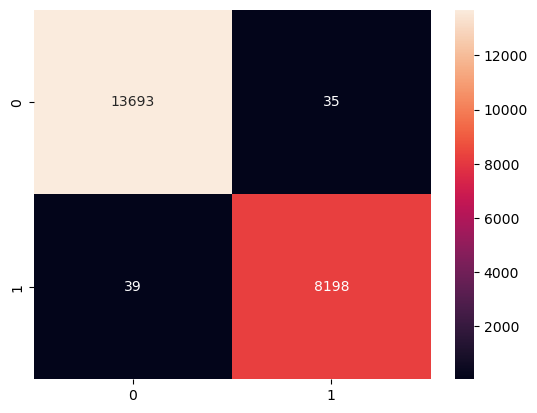

In [5]:
pred = model.predict(x_train.iloc[best_fold_val_idx])

cm = confusion_matrix(y_train[best_fold_val_idx], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# Testing

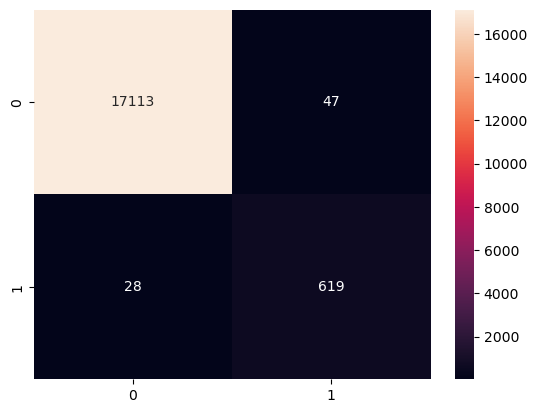

In [6]:
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [7]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17160
         1.0       0.93      0.96      0.94       647

    accuracy                           1.00     17807
   macro avg       0.96      0.98      0.97     17807
weighted avg       1.00      1.00      1.00     17807



In [8]:
print(f1_score(y_test, pred))

0.9428789032749428
